# HOW BOOSTING THE RATING OF A FEATURE WILL AFFECT OVERALL RATING OF AN AIRLINE

In the service industry, keep high customer satisfaction is always among the top priority. Hence, for all airlines understanding how customers view their service through reviews are good metrics to measure the performance. Skytrax website has long been a great site for customers reviews of airlines, where it collects reviews and ratings for each airlines, lounges, seats and airports. However, there are a lot of feature ratings that an airline should consider to improve their general customer satisfaction, so it is highly important for airlines to put some priorities on which to focus and invest more effort in. 
In this project, my aim is to find the most important features that ailines should put higher weight of effort and a quantitative metrics on how to improve their ratings.

### Data
The data is scraped from airlinequality.com by quankiquanki: https://github.com/quankiquanki/skytrax-reviews-dataset. The airline dataset has a total sample of 42.396 observations with 20 columns containing information of ailines, the reviewers and their ratings for each features as well as comments on the airlines. The ratings for each feature range from 1 to 5, while overall rating is from 1 to 10. 

### Approach
* First, I build a model that can predict well the overall rating based on each feature's rating. In order to do that, I conduct OLS Linear model, Ridge linear for parameter regularization and random forest. 
* Then, I select the best model among these methods and choose the important features for airlines.
* Finally, using these features on the best models, I get the predicted rating for airlines and using this result for analyzing the possible improvement of overall rating on some feature ratings.

### Result
While OLS has the greatest fit in R^2, its mean squared error (MSE) is much higher than other two models. Random forest is the best performance on both train and test set with the lowest MSE of 1.87. The most important factors that may affect overall rating are value-money rating (46.6%), cabin staff (20.5%), seat comfort (14.5), food beverages (11%) and inflight entertainment (5.7%). 

### Further research
* Conduct the same approach for a specific airline. 
* Do topic and sentiment analysis on the travellers' reviews for this airline to see which topics are most discussed, and alerts on negative reviews to take in-time action.


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

In [88]:
df=pd.read_csv('skytrax-reviews-dataset-master/data/airline.csv')

In [89]:
df.head(2)

,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1


## Data exploration

In [90]:
df.describe()

C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
count,36861.000000,33706.000000,33708.000000,33264.000000,31114.000000,2203.000000,565.000000,39723.000000,41396.000000
mean,6.039527,3.094612,3.319212,2.805886,2.392364,2.736723,2.249558,3.164111,0.533820
std,3.214680,1.405515,1.541307,1.580246,1.704753,1.569073,1.541283,1.523486,0.498861
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
max,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41396 entries, 0 to 41395
Data columns (total 20 columns):
airline_name                     41396 non-null object
link                             41396 non-null object
title                            41396 non-null object
author                           41396 non-null object
author_country                   39805 non-null object
date                             41396 non-null object
content                          41396 non-null object
aircraft                         1278 non-null object
type_traveller                   2378 non-null object
cabin_flown                      38520 non-null object
route                            2341 non-null object
overall_rating                   36861 non-null float64
seat_comfort_rating              33706 non-null float64
cabin_staff_rating               33708 non-null float64
food_beverages_rating            33264 non-null float64
inflight_entertainment_rating    31114 non-null float64
ground_se

* From this descriptive table, we see that we only have problem with missing values, but there is no outliers. Note that for some features, we see the min of rating is 0, which is invalid (from 1 to 5) so those are also missing values. 
* It is noticeable that data for overall rating, recommended and value_money rating are nearly full while rating data for ground service and wifi connectivity are mostly missing.However, we should not assume that it is becaus travellers tend to pay more attention to these rating when they score and leave out other ratings or because some airlines simply don't provide these amenities in some routes. Hence, I think it's more logical to replace those missing values by 0 than by imputed values(mean, median). 
* The data points with missing values for overall rating will be deleted as it is our main concern. 

* we will need to change some categorical features above into category type. Date into date type, but we may not need it in this model

In [92]:
df.groupby('type_traveller').size()

type_traveller
Business          362
Couple Leisure    601
FamilyLeisure     611
Solo Leisure      804
dtype: int64

* This shows that we have lots of missing data for type of travellers

In [93]:
df.groupby('cabin_flown').size()

cabin_flown
Business Class      6347
Economy            29784
First Class          879
Premium Economy     1510
dtype: int64

* Those missing points in this case are not many, so we just replace with 0 for missing values

In [94]:
len(df['airline_name'].unique()) #how many airlines operate

362

In [95]:
len(df['author_country'].unique()) #to see whether the reviews come from just some countries

159

In [96]:
len(df['aircraft'].unique()) #how many types of aircraft

364

In [97]:
len(df['route'].unique()) #how many routes

2209

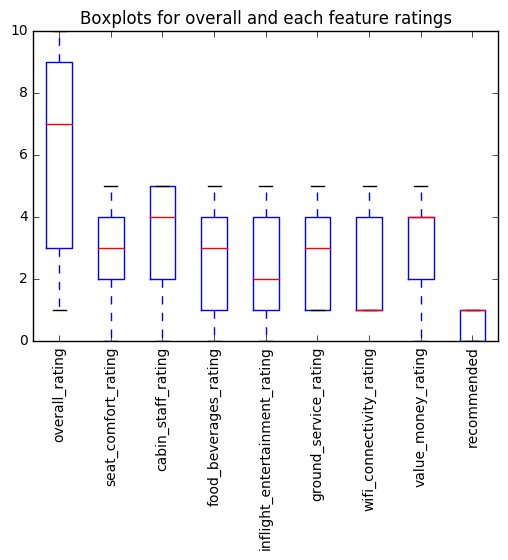

In [98]:
df.plot.box()
plt.xticks(rotation='vertical')
plt.title('Boxplots for overall and each feature ratings')
plt.show()

* the boxplot may not be useful yet because of many missing values and denoted as 0 in our data

## Data wrangling

In the data cleaning step, I do the following:
* Only choose data since 2010
* Drop data without overall rating
* Drop information that is not needed for feature selection purpose: link, title, author, author country, date, content, aircraft type, route
* Encode missing values as 0
* Get dummies for traveller type and cabin flown 

In [99]:
df.date=pd.to_datetime(df.date) #change date object into datetime format
df=df[df.date>='2010-01-01'] #choose recent dates only
df.shape

(39539, 20)

In [100]:
#drop data points without overall rating
df_clean=df[df['overall_rating'].notnull()]

In [101]:
#'link','title','author','author_country','date','content','aircraft','route'
df_clean.drop(['airline_name','link','title','author','author_country','date','content','aircraft','route'],axis=1, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [102]:
df_clean.head()

,type_traveller,cabin_flown,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,NaN,Economy,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,NaN,Business Class,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1
2,NaN,Economy,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1
3,NaN,Business Class,8.0,4.0,4.0,3.0,1.0,NaN,NaN,4.0,1
4,NaN,Economy,4.0,4.0,2.0,1.0,2.0,NaN,NaN,2.0,0


In [103]:
#deal with missing values
df_clean=df_clean.fillna({'ground_service_rating':0, 'wifi_connectivity_rating':0,'seat_comfort_rating':0,'cabin_staff_rating':0,'food_beverages_rating':0,'inflight_entertainment_rating':0, 'value_money_rating':0}, inplace=True)


C:\Users\Bao Tram\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [104]:
#replace missing value of categorical variables with their mode
#df_clean=df_clean.fillna(df_clean.mode().iloc[0])


In [105]:
#change types cabin flown and traveler types into category type
df_cabin_flown= pd.get_dummies(df_clean['cabin_flown'])
df_clean=pd.concat([df_clean, df_cabin_flown], axis=1)
df_clean.drop(['cabin_flown'], axis=1, inplace=True)

df_type_traveller= pd.get_dummies(df_clean['type_traveller'])
df_clean=pd.concat([df_clean, df_type_traveller], axis=1)
df_clean.drop(['type_traveller'], axis=1, inplace=True)

In [106]:
df_clean.isnull().values.any() #check if there are any missing values in dataframe

False

In [107]:
df_clean.head()

,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended,Business Class,Economy,First Class,Premium Economy,Business,Couple Leisure,FamilyLeisure,Solo Leisure
0,7.0,4.0,4.0,4.0,0.0,0.0,0.0,4.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,4.0,5.0,4.0,1.0,0.0,0.0,5.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,5.0,5.0,4.0,0.0,0.0,0.0,5.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8.0,4.0,4.0,3.0,1.0,0.0,0.0,4.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,4.0,2.0,1.0,2.0,0.0,0.0,2.0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
df_clean.shape

(35799, 17)

In [109]:
df_clean.corr()

,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended,Business Class,Economy,First Class,Premium Economy,Business,Couple Leisure,FamilyLeisure,Solo Leisure
overall_rating,1.000000,0.462164,0.500847,0.444094,0.287536,0.027525,0.000431,0.813393,0.870102,0.111079,-0.061186,0.027171,-0.014674,-0.049340,-0.051029,-0.056563,-0.033996
seat_comfort_rating,0.462164,1.000000,0.788034,0.721929,0.560922,0.079728,0.040786,0.537106,0.407606,0.133499,-0.118492,0.067202,0.038234,0.003044,-0.000575,-0.003312,0.018895
cabin_staff_rating,0.500847,0.788034,1.000000,0.765147,0.527278,0.092275,0.038081,0.542741,0.450083,0.125693,-0.106320,0.046118,0.036429,0.003686,0.007150,-0.000294,0.025469
food_beverages_rating,0.444094,0.721929,0.765147,1.000000,0.623340,0.054135,0.037187,0.490241,0.391975,0.180899,-0.155305,0.054012,0.046372,-0.005376,-0.019229,-0.020159,-0.005065
inflight_entertainment_rating,0.287536,0.560922,0.527278,0.623340,1.000000,0.034209,0.066826,0.333109,0.247565,0.178171,-0.181563,0.062387,0.084218,-0.004268,-0.020065,-0.021439,-0.010602
ground_service_rating,0.027525,0.079728,0.092275,0.054135,0.034209,1.000000,0.428163,0.037458,0.034179,0.005172,0.007803,0.025967,-0.014739,0.293762,0.405659,0.419405,0.471841
wifi_connectivity_rating,0.000431,0.040786,0.038081,0.037187,0.066826,0.428163,1.000000,0.006540,0.002848,0.002734,-0.005983,0.033684,-0.004293,0.178804,0.179142,0.221789,0.186764
value_money_rating,0.813393,0.537106,0.542741,0.490241,0.333109,0.037458,0.006540,1.000000,0.773189,0.088623,-0.028545,0.008951,-0.019167,-0.043423,-0.044457,-0.045927,-0.022110
recommended,0.870102,0.407606,0.450083,0.391975,0.247565,0.034179,0.002848,0.773189,1.000000,0.095460,-0.047063,0.019449,-0.018040,-0.035739,-0.041444,-0.047779,-0.021885
Business Class,0.111079,0.133499,0.125693,0.180899,0.178171,0.005172,0.002734,0.088623,0.095460,1.000000,-0.747243,-0.070230,-0.092920,0.052992,-0.012931,-0.037327,-0.016014


From the above table, we see that there are much correlations between seat comfort rating, cabin staff, food beverages rating and inflight entertainment rating. Hence, there might be huge bias in case of OLS due to multi-colinearity

## Modelling

In order to get the most important features that may affect overall rating, the following steps are conducted:
    * Classifiers: OLS, Ridge regression,  Random forest
    * Divide dataset into train/testset, grid search and cross validation with 10 folds 
    * Metrics: R^2 and RMSE(root mean squared error)

In [110]:
y=df_clean.overall_rating
X=df_clean.drop(['overall_rating', 'recommended'], axis=1)

In [111]:
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X,y,random_state=1)
from sklearn.metrics import mean_squared_error

### Simple OLS

In [112]:
import statsmodels.api as sm
model=sm.OLS(ylr, Xlr)
results = model.fit()
print(results.summary())
print('mean squared error on ols:', results.mse_resid)

                            OLS Regression Results                            
Dep. Variable:         overall_rating   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.297e+04
Date:                Sat, 29 Oct 2016   Prob (F-statistic):               0.00
Time:                        11:50:06   Log-Likelihood:                -54643.
No. Observations:               26849   AIC:                         1.093e+05
Df Residuals:                   26834   BIC:                         1.094e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
seat_comfort_r

#### Result analysis

Though R^2 is quite high 92.8%, the assumptions for OLS may not hold (multi-colinearity). Thus, as coefficients are biased, we cannot interpret the results from OLS.

One weird observation is that seat comfort rating and inflight entertainment rating though are statistically significant, have negative coefficients (we expect all of the features should have positive effect on overall rating). But we will come back to this point after analyzing other models.

### Ridge regression

In [113]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV
ridge_model=RidgeCV(alphas=(0,0.1,0.3, 0.5,0.7,1.0, 10.0), cv=10).fit(Xlr,ylr)
model=SelectFromModel(ridge_model, prefit=True)
model_new=model.transform(Xlr)

In [114]:
#RSS_ridge=sum((ridge_model.predict(Xlr)-ylr)**2)
print('alpha=', ridge_model.alpha_)
print('R^2 score: ',ridge_model.score(Xlr,ylr))
print('mean squared error on train set:', mean_squared_error(ylr,ridge_model.predict(Xlr)))

RSS_ridge=sum((ridge_model.predict(Xtestlr)-ytestlr)**2)
print('R^2 on test set: ',ridge_model.score(Xtestlr,ytestlr))
print('mean squared error on test set:', mean_squared_error(ytestlr,ridge_model.predict(Xtestlr)))

alpha= 1.0
R^2 score:  0.669865949403
mean squared error on train set: 3.42980075469
R^2 on test set:  0.679989028095
mean squared error on test set: 3.32571734039


#### Result analysis
The test set performs better than the train set, thus suggesting underfitting in our model. 

### Random forest

In [115]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
forest=RandomForestRegressor(max_features = "sqrt", random_state=1)
param_grid = { "n_estimators"      : [200, 300],
           "max_depth"         : [10, 20],
           "min_samples_split" : [2, 4]}
%timeit
grid_search = GridSearchCV(forest, param_grid, n_jobs=-1, cv=10, scoring='mean_squared_error')
grid_search.fit(Xlr, ylr)
print(grid_search.best_params_)

{'max_depth': 10, 'n_estimators': 300, 'min_samples_split': 4}


In [116]:
best_max_depth, best_samples_splits, best_n_esti=grid_search.best_params_.values()
print('best mean squared error:',grid_search.best_score_)

best mean squared error: -1.91346952336


In [117]:
forest=RandomForestRegressor(max_features = "sqrt", random_state=1,n_estimators=best_n_esti, min_samples_split=best_samples_splits,
                             max_depth=best_max_depth).fit(Xlr,ylr)
importances = forest.feature_importances_
names=list(Xlr.columns.values)
features = []
indices = np.argsort(importances)[::-1]

for f in range(len(importances)):
    print("%d. feature %d (%f), %s" % (f + 1, indices[f], importances[indices[f]], names[indices[f]]))
    features.append(indices[f])
    # Print only first 10 most important variables
    if len(features) >= 10:
        break
featurenames = [names[feature] for feature in features]

1. feature 6 (0.629578), value_money_rating
2. feature 1 (0.223608), cabin_staff_rating
3. feature 2 (0.049306), food_beverages_rating
4. feature 0 (0.043799), seat_comfort_rating
5. feature 3 (0.042340), inflight_entertainment_rating
6. feature 7 (0.004652), Business Class
7. feature 4 (0.002374), ground_service_rating
8. feature 5 (0.001565), wifi_connectivity_rating
9. feature 14 (0.000673), Solo Leisure
10. feature 8 (0.000651), Economy


Feature ranking:


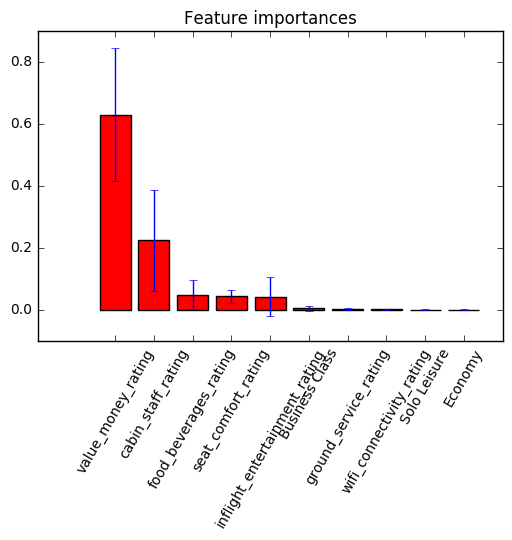

In [118]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)

# Plot the feature importances of the forest
print('Feature ranking:')
fig=plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices[0:10]],
       color="r", yerr=std[indices[0:10]], align="center")
plt.xticks(range(len(features)), featurenames,rotation=60)
plt.show()
fig.savefig('feature important.png')

In [119]:
print('mean squared error on train set:', mean_squared_error(ylr,forest.predict(Xlr) ))
print('mean squared error on test set:', mean_squared_error(ytestlr,forest.predict(Xtestlr)))
print('R^2 on test set: ',forest.score(Xtestlr,ytestlr))

mean squared error on train set: 2.05628078549
mean squared error on test set: 2.04202079962
R^2 on test set:  0.803510342625


#### Result analysis

Based on R^2 and MSE, we see that random forest performs better than Ridge regression for both train and test set. Hence, we will
use random forest for building our model.

In the following, I group the rating for each feature where 1-3 is recorded as low, and 4-5 as high. Then, I take the median of predicted overall rating over these subsets of each feature. 

In [138]:
data_predict=Xtestlr.copy()
data_predict['value_money_low']=(data_predict.value_money_rating<=3)
data_predict['cabin_low']=(data_predict.cabin_staff_rating<=3)
data_predict['seat_comfort_low']=(data_predict.seat_comfort_rating<=3)
data_predict['food_beverages_low']=(data_predict.food_beverages_rating<=3)
data_predict['inflight_entertainment_low']=(data_predict.inflight_entertainment_rating<=3)
data_predict['y']=forest.predict(Xtestlr)
pd.pivot_table(data=data_predict,columns=None, index='value_money_low',values='y', aggfunc='median')

value_money_low
False    8.305249
True     2.945782
Name: y, dtype: float64

In [139]:
pd.pivot_table(data=data_predict,columns=None, index='cabin_low',values='y', aggfunc='median')

cabin_low
False    8.493133
True     3.259240
Name: y, dtype: float64

In [140]:
pd.pivot_table(data=data_predict,columns=None, index='seat_comfort_low',values='y', aggfunc='median')

seat_comfort_low
False    8.598141
True     3.839813
Name: y, dtype: float64

In [141]:
pd.pivot_table(data=data_predict,columns=None, index='food_beverages_low',values='y', aggfunc='median')

food_beverages_low
False    8.741071
True     4.261718
Name: y, dtype: float64

In [142]:
pd.pivot_table(data=data_predict,columns=None, index='inflight_entertainment_low',values='y', aggfunc='median')

inflight_entertainment_low
False    8.582835
True     5.659227
Name: y, dtype: float64

In [143]:
pd.pivot_table(data=data_predict,columns=None, index=['value_money_low','cabin_low','seat_comfort_low','food_beverages_low','inflight_entertainment_low'],values='y', aggfunc='mean')

value_money_low  cabin_low  seat_comfort_low  food_beverages_low  inflight_entertainment_low
False            False      False             False               False                         9.026197
                                                                  True                          8.787883
                                              True                False                         8.110424
                                                                  True                          8.349091
                            True              False               False                         7.830798
                                                                  True                          8.104806
                                              True                False                         6.809716
                                                                  True                          7.664592
                 True       False             False               F

##### The above table can be interpreted as follows:

We may go upwards or downwards in this table. If we take from bottom up, we see when everything is True, that is when every of these features have low rating, the median overall rating will be 2.538 point. Raising inflight entertainment rating from low (1-3) to high rate (4-5), the overall rating increases by nearly 1 point. And the analysis continues this way. This table can serve as a relative reference table for performance tracking purpose.   
